In [1]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
# Load embeddings and filenames
fused_embeddings = np.load("fused_embeddings_rev.npy")
with open("fused_filenames_rev.txt", "r") as f:
    filenames = [line.strip() for line in f.readlines()]

# Compute similarity matrix
similarity_matrix = cosine_similarity(fused_embeddings)

# Define threshold for similarity-based graph
SIMILARITY_THRESHOLD = 0.9995

In [46]:
# Create Graph
G = nx.Graph()

# Add nodes (each filename as a unique node)
for filename in filenames:
    G.add_node(filename)

# Add edges based on similarity threshold
for i in range(len(filenames)):
    for j in range(i + 1, len(filenames)):  # Avoid duplicate edges
        if similarity_matrix[i, j] > SIMILARITY_THRESHOLD:
            G.add_edge(filenames[i], filenames[j], weight=similarity_matrix[i, j])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 740 nodes and 23079 edges.


In [47]:
import community  # Requires python-louvain package

# Perform Louvain Community Detection
partition = community.best_partition(G)

# Assign communities to each node
for node in G.nodes():
    G.nodes[node]['community'] = partition[node]

print(f"Detected {len(set(partition.values()))} communities.")

Detected 19 communities.


In [48]:
# Compute PageRank (importance of coins)
pagerank_scores = nx.pagerank(G)

# Compute Betweenness Centrality (bridge nodes)
betweenness_centrality = nx.betweenness_centrality(G)

# Assign scores to nodes
for node in G.nodes():
    G.nodes[node]["pagerank"] = pagerank_scores[node]
    G.nodes[node]["betweenness"] = betweenness_centrality[node]


c:\Users\Kenan\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



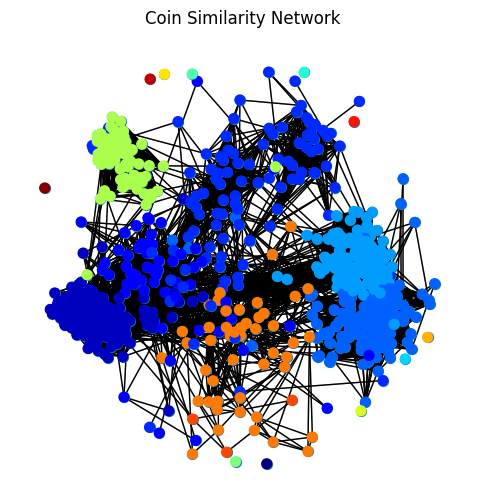

In [49]:
import matplotlib.pyplot as plt

# Draw the Graph
plt.figure(figsize=(6, 6))

# Assign colors based on communities
node_colors = [partition[node] for node in G.nodes()]

# Position nodes using a force-directed layout
pos = nx.spring_layout(G, k=0.6, iterations=100)
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.viridis)
nx.draw_networkx_edges(G, pos, alpha=0.3)
# Draw the network
nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, cmap=plt.cm.jet)

plt.title("Coin Similarity Network")
plt.show()

# pos = nx.kamada_kawai_layout(G)  # Alternative spacing
# nx.draw(G, pos, node_size=50, edge_color="gray", alpha=0.5)
# plt.title("Coin Similarity Network (Kamada-Kawai Layout)")
# plt.show()

# pos = nx.fruchterman_reingold_layout(G, k=0.7, iterations=200)
# nx.draw(G, pos, node_size=50, edge_color="gray", alpha=0.5)
# plt.title("Coin Similarity Network (Fruchterman-Reingold Layout)")
# plt.show()



In [50]:
def similarity_matrix_to_graph(similarity_matrix, filenames, threshold=0.9):
    G = nx.Graph()
    num_nodes = similarity_matrix.shape[0]

    # Add nodes
    for filename in filenames:
        G.add_node(filename)

    # Add edges for similarities above threshold
    for i in range(len(filenames)):
        for j in range(i + 1, len(filenames)):  # Avoid duplicate edges
            if similarity_matrix[i, j] > threshold:
                G.add_edge(filenames[i], filenames[j], weight=similarity_matrix[i, j])

    return G

In [52]:
import plotly.graph_objects as go
import networkx as nx

# Create a sample NetworkX graph
G = similarity_matrix_to_graph(similarity_matrix, filenames, threshold=0.9995) 

# Get node positions
pos = nx.spring_layout(G)

# Create edges
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)  # Separator
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color="gray"),
    hoverinfo="none",
    mode="lines"
)

# Create nodes
node_x = []
node_y = []
node_text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)  # Use filename as hover text

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode="markers",
    hoverinfo="text",
    text=node_text,
    marker=dict(size=10, color="blue")
)

# Create interactive figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Interactive Coin Similarity Graph",
                    showlegend=False,
                    hovermode="closest",
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()